In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# DataFrames 
players = pd.read_csv("datasets/players.csv")
players_stats = pd.read_csv("datasets/player_szn_stats.csv")
nba_teams = pd.read_csv("datasets/teams.csv")
szn_types = pd.read_csv("datasets/szn_types.csv")
szn_stats = pd.read_csv("datasets/Seasons_Stats.csv") 


In [19]:
def clean_name(s: str):
    """
    cleans the name of the players, in the szn stats dataset some have a '*' at the end of their name
    """
    if isinstance(s, str) and s.endswith("*"):
        return s[:-1]
    return s

In [20]:
szn_stats["Player"] = szn_stats["Player"].apply(clean_name)

In [21]:
merged = players_stats.merge(nba_teams, on="team_id")
merged = merged.merge(players, on="player_id")
merged["player_name"] = merged["first_name"] + " " + merged["last_name"]
merged = merged[["player_id", "full_name", "season_id", "player_name", "league_id_x", "minutes", "weight_lb"]].drop_duplicates()


### Descriptive analysis of the dataset

Lets take a look at who are the players and teams that have performed the best over the years. For this analysis we will only be looking at the NBA, and regular season statistics.


In [22]:
top_scoring_players = szn_stats[["Player", "PTS", "Year"]].groupby("Player").sum().sort_values(by="PTS", ascending=False).head(5)
top_players = top_scoring_players.index

In [23]:
player_with_teams = szn_stats.merge(merged, left_on="Player", right_on="player_name")

In [24]:
top_scoring_teams = player_with_teams.groupby("full_name").sum().sort_values(by="PTS", ascending=False).head(5)
top_teams = top_scoring_teams.index

## Players

<Axes: title={'center': 'Top Scoring players'}, xlabel='Player', ylabel='Points'>

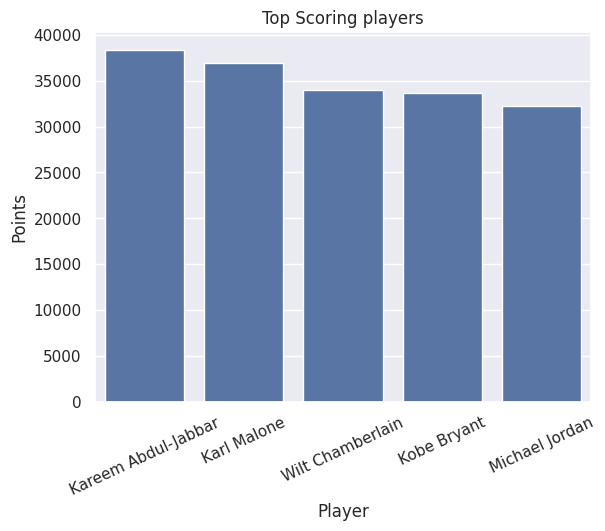

In [25]:
def plot_top_scoring_players():
    plot = sns.barplot(data=top_scoring_players, y="PTS", x="Player")
    plot.set(title="Top Scoring players", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

plot_top_scoring_players()

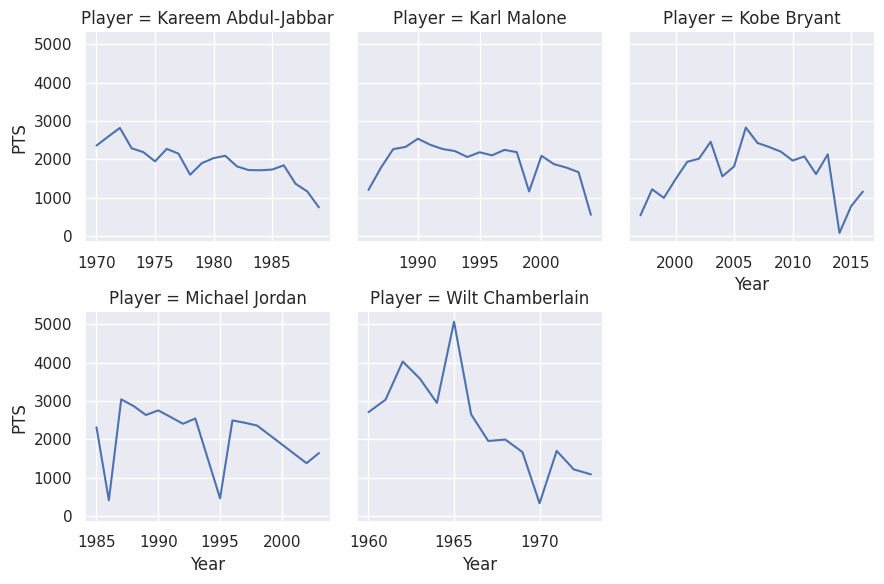

In [26]:
def plot_top_scoring_players_over_time():
    players_per_year = szn_stats[szn_stats["Player"].isin(top_players)].groupby(["Player", "Year"]).sum().reset_index()
    g = sns.FacetGrid(players_per_year, col="Player", sharex=False, col_wrap=3)
    g.map(sns.lineplot, "Year", "PTS")
    return g

plot_top_scoring_players_over_time()

But are these really the best players? What if a player or team has played more games. Let's take a look at averages during the years, and see if there is anything that changes. 

<Axes: title={'center': 'Avg points scored per season'}, xlabel='Player', ylabel='Points'>

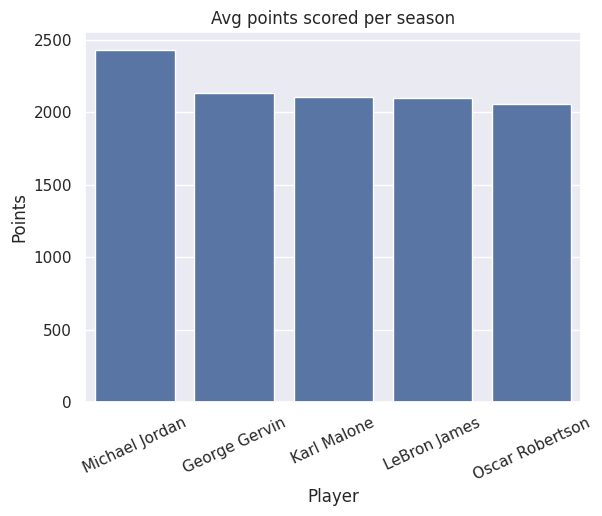

In [27]:
def get_players_with_highest_pts_avg(): 
    avg_top_scoring_players = szn_stats[["Player", "PTS"]].groupby("Player").median().sort_values(by="PTS", ascending=False).head(5)
    plot = sns.barplot(data=avg_top_scoring_players.reset_index(), y="PTS", x="Player")
    plot.set(title="Avg points scored per season", xlabel="Player", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

get_players_with_highest_pts_avg()
    

## Who have been the best shooters? (True shooting %)

True shooting percentage shows who have been the best shooters across all possible scoring types.

True shooting percentage is defined as

$$ TS\% = {PTS \over 2FGA + 0.475FTA} $$ 



                    G        TS%
Player                          
Artis Gilmore   980.0  64.170482
Dave Twardzik   280.0  63.952484
Rudy Gobert     269.0  63.313079
DeAndre Jordan  673.0  63.067515
Cedric Maxwell  916.0  62.895257


<Axes: title={'center': 'Top 5 shooters all time'}, xlabel='Player', ylabel='True Shooting Percentage'>

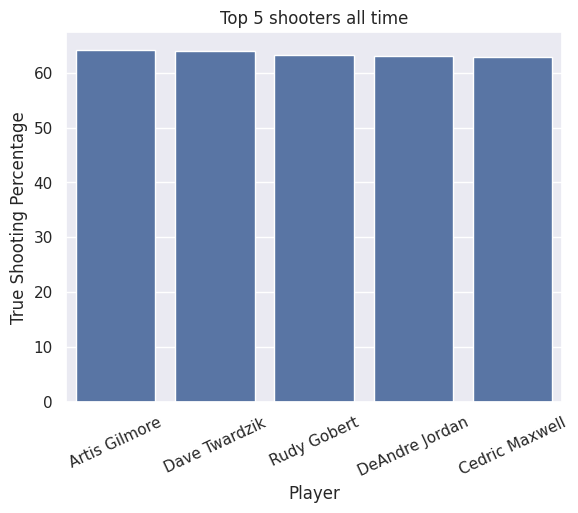

In [46]:
def get_true_shooting_percentages():
    best_shooters = szn_stats[["Player", "FGA", "FTA", "PTS", "GS", "Year"]].groupby("Player").sum().sort_values(by="PTS", ascending=False)
    best_shooters['TS%'] = (best_shooters['PTS'] / (2 * (best_shooters['FGA'] + 0.475 * best_shooters['FTA']))) * 100
    best_shooters = best_shooters[best_shooters["GS"] > 250][["GS","TS%"]].sort_values(by="TS%", ascending=False)
    plot = sns.barplot(data=best_shooters.reset_index().head(5), y="TS%", x="Player")
    plot.tick_params(axis="x", rotation=25)
    plot.set(title="Top 5 shooters all time", xlabel="Player", ylabel="True Shooting Percentage", )
    print(best_shooters.head(5))
    return plot

get_true_shooting_percentages()


## Effective field goal percentage

it shows how efficient the player is at shooting three point shots and also 2 point shots

and it is defined as follows:

$$ eFG\% = {FG + 0.5\times3PM \over FGA}$$

<Axes: title={'center': 'Top 5 players with effective field goal percentage'}, xlabel='Player', ylabel='eFG%'>

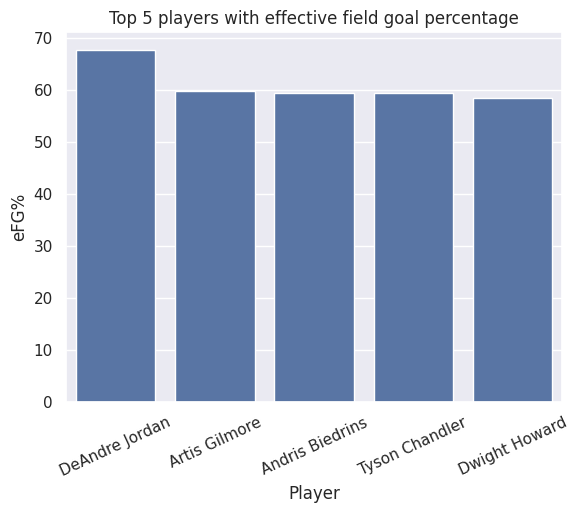

In [50]:
def show_effective_fild_goal_percentage():
    best_shooters = szn_stats[["Player", "FG", "FGA", "Year", "3P", "GS"]].groupby("Player").sum().sort_values(by="FG", ascending=False)
    best_shooters["eFG%"] = ((best_shooters["FG"] + 0.5 * best_shooters["3P"]) / best_shooters["FGA"]) * 100
    best_shooters = best_shooters[best_shooters["GS"] > 250][["GS", "eFG%"]].sort_values(by="eFG%", ascending=False)
    plot = sns.barplot(data=best_shooters.reset_index().head(5), y="eFG%", x="Player")
    plot.set(title="Top 5 players with effective field goal percentage", xlabel="Player", ylabel="eFG%")
    plot.tick_params(axis="x", rotation=25)
    return plot
show_effective_fild_goal_percentage()

Note that, it is interesting that our best shooters, are not in the part of the players with highest average points scored per season

## Teams 

lets analyse who have been the most dominants teams over the years

<Axes: title={'center': 'Top Scoring teams all Time'}, xlabel='Team', ylabel='Total Points'>

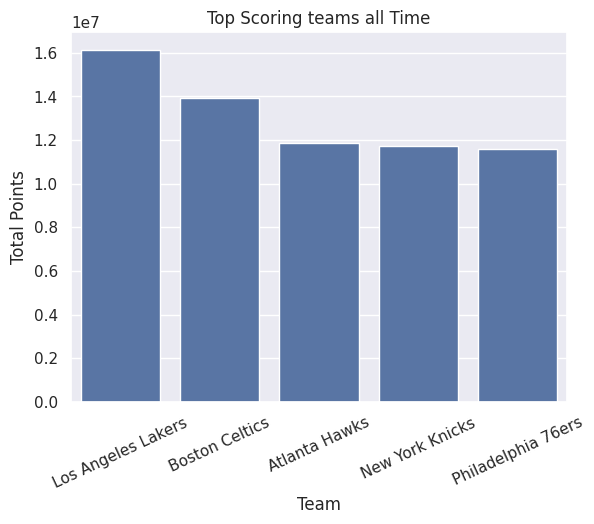

In [30]:
def plot_top_scoring_teams():
    """
    returns an axes with the top scoring teams all time as of 2020
    """
    plot = sns.barplot(data=top_scoring_teams.reset_index(), y="PTS", x="full_name")
    plot.set(title="Top Scoring teams all Time", xlabel="Team", ylabel="Total Points")
    plot.tick_params(axis="x", rotation=25)

    return plot

plot_top_scoring_teams()

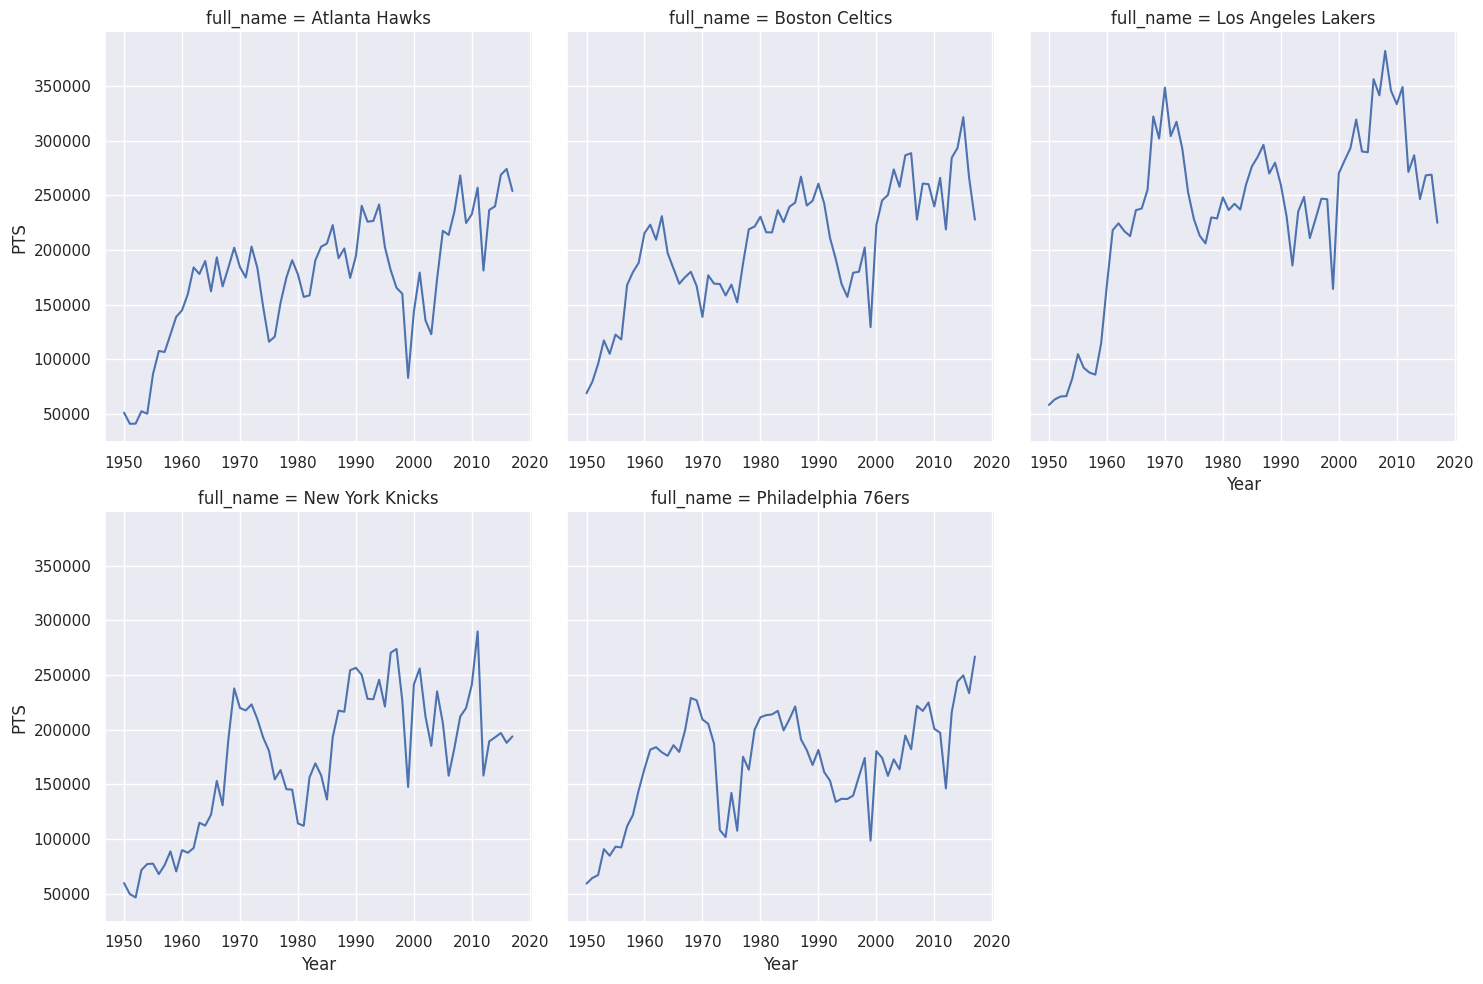

In [31]:
def plot_top_scoring_teams_over_time():
    team_points_per_year = player_with_teams[player_with_teams["full_name"].isin(top_teams)].groupby(["full_name", "Year"]).sum().reset_index()
    plot = sns.FacetGrid(data=team_points_per_year, col="full_name", col_wrap=3, height=5, sharex=False)
    plot.map(sns.lineplot, "Year", "PTS")
    return plot

plot_top_scoring_teams_over_time()

## Assists to turnover ratio

It is said that elite teams are the ones producing the most amounts of assists and the least turnovers, lets take a look at which teams have been the best at doing so over the years 

In [71]:
def teams_w_best_ast_tov_ration():
    teams_per_year = player_with_teams[player_with_teams["Year"] > 2000][["full_name", "TOV", "AST", "G"]].groupby("full_name").sum().reset_index()
    teams_per_year = teams_per_year[teams_per_year["TOV"] > 0]
    teams_per_year["AST/TOV"] = teams_per_year["AST"] / teams_per_year["TOV"]
    teams_per_year = teams_per_year[teams_per_year["G"] > 10000]
    teams_per_year = teams_per_year.sort_values(by="AST/TOV", ascending=False)
    print(teams_per_year.head(10))

teams_w_best_ast_tov_ration()

                 full_name       TOV        AST         G   AST/TOV
10        Dallas Mavericks  697274.0  1249989.0  475166.0  1.792680
29            Phoenix Suns  504428.0   888599.0  332955.0  1.761597
39               Utah Jazz  504952.0   871411.0  352508.0  1.725730
4            Brooklyn Nets  529023.0   900797.0  367668.0  1.702756
34       San Antonio Spurs  744200.0  1261012.0  499821.0  1.694453
18    Los Angeles Clippers  577750.0   975774.0  376258.0  1.688921
23  Minnesota Timberwolves  403850.0   680464.0  290688.0  1.684942
38         Toronto Raptors  413863.0   689145.0  309289.0  1.665152
24    New Orleans Pelicans  372592.0   619993.0  275131.0  1.664000
13         Detroit Pistons  480169.0   793301.0  360767.0  1.652129


Interestingly enough, these teams do not seem to be the most successful ones the NBA.